# Photometry data preprocessing

This notebook shows methods for preprocessing fiber photometry data. The preprocessing consists of the following steps:

1. Lowpass filtering to reduce noise.

2. Correction for photobleaching, i.e. the slow decreace in the fluorescence signal over time.  Two different methods are shown (i) subtraction of a double exponential fit (ii) highpass filtering with a very low cutoff frequency.

2. Movement correction by subtracting a linear fit of the movement control channel.

4. Conversion of the signal to dF/F.

Note that different groups do preprocessing differently and there is no universally accepted best practice for how to preprocess photometry data.  The best way to preprocess your data may depend on the details of the experimental setup and the questions you want to ask of the data. It is good practice to always visually inspect the raw data and the results of each preprocessing step to make sure they look sensible.  

The data used in this notebook were recorded from dLight expressed in the nucleus accumbens core during a reward guided decision task ([Blanco-pozo et al 2023](https://www.biorxiv.org/content/10.1101/2021.06.25.449995v3)).  The data were recorded using [pyPhotometry](https://pyphotometry.readthedocs.io) acquisition hardware, using the *two colour time division* acquisition mode with dLight as the dopamine sensor  and TdTomato as a movement control channel.

Import the standard python modules needed for the analysis.

In [18]:
import os
import numpy as  np
import pylab as plt
from scipy.signal import medfilt, butter, filtfilt
from scipy.stats import linregress
from scipy.optimize import curve_fit, minimize

#set default plot properties
plt.rcParams['figure.figsize'] = [14, 12] # Make default figure size larger.
plt.rcParams['axes.xmargin'] = 0          # Make default margin on x axis zero.
plt.rcParams['axes.labelsize'] = 12     #Set default axes label size
plt.rcParams['axes.titlesize']=15
plt.rcParams['axes.titleweight']='heavy'
plt.rcParams['ytick.labelsize']= 10
plt.rcParams['xtick.labelsize']= 10
plt.rcParams['legend.fontsize']=12
plt.rcParams['legend.markerscale']=2

Import the photometry data and times of reward cues.

In [ ]:
folder_path = '//'
filename = '.csv'
#今回のデータはcsvなのでコメントアウトする
#data = import_ppd(os.path.join(data_folder, data_filename))

import pandas as pd
my_data_path = os.path.join(folder_path, filename)
df = pd.read_csv(my_data_path)

/var/folders/w4/r7x4d36n3cxc1hr4gsm3crsh0000gn/T/ipykernel_5195/3380305827.py:8: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(my_data_path)


Extract the raw dLight and TdTomato signals, session time, and sampling rate.

In [ ]:
#サンプリングレートも30としました。
#⭐︎⭐︎⭐︎⭐︎⭐︎⭐︎⭐︎⭐︎⭐︎⭐︎⭐︎⭐︎⭐︎⭐︎⭐︎⭐︎⭐︎⭐︎⭐︎⭐︎⭐︎⭐︎⭐︎⭐︎⭐︎⭐︎⭐︎⭐︎⭐︎⭐︎
ch470_raw = df['CH1-470'].values
ch410_raw = df['CH1-410'].values
time_seconds = df['TimeStamp'].values / 1000
sampling_rate = 30

# Raw signals

Let's take a look at the raw dLight and TdTomato signals.

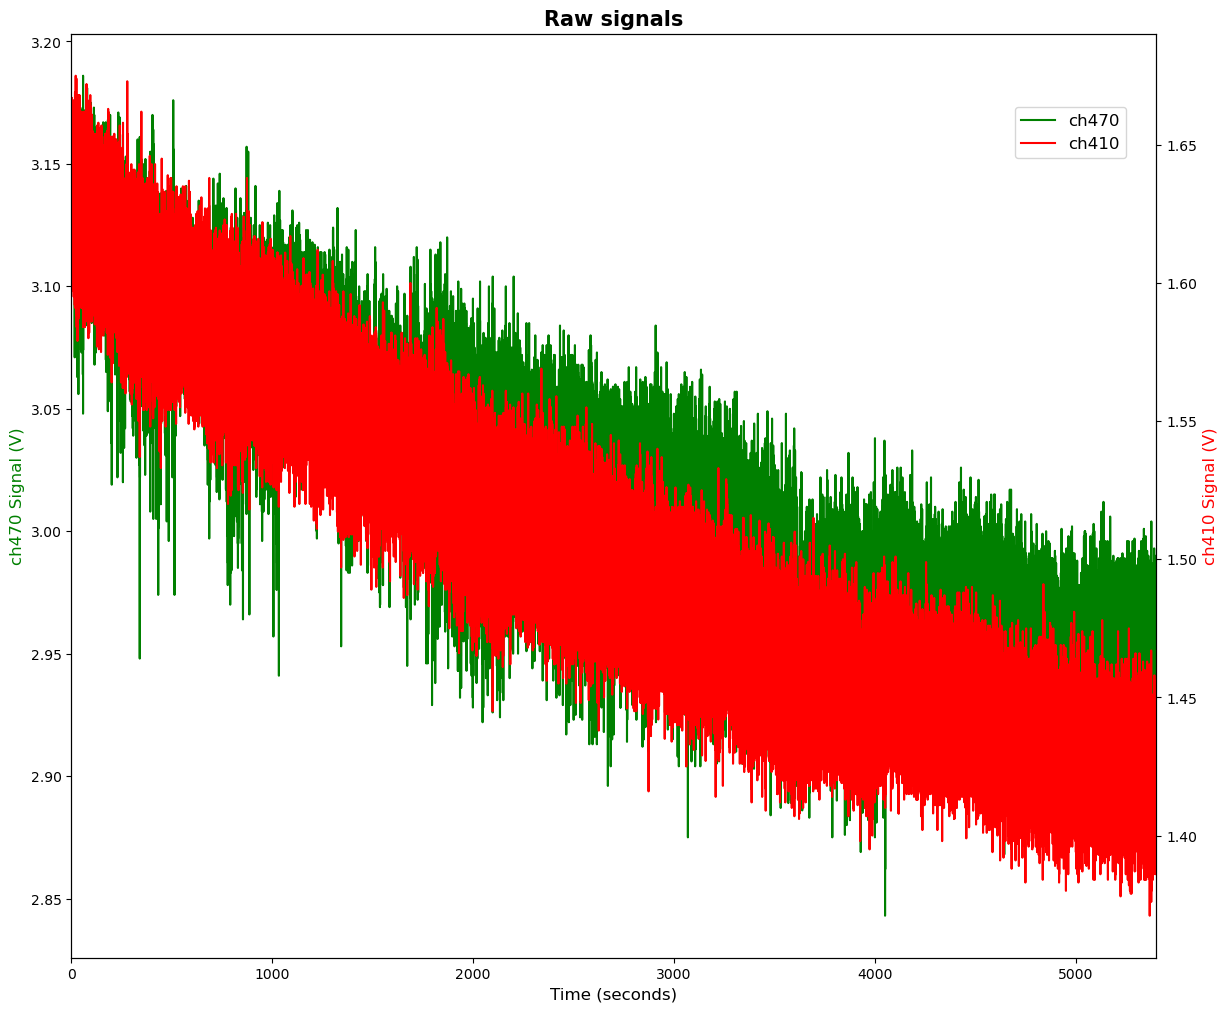

In [21]:
# Plot signals

fig,ax1=plt.subplots()  # create a plot to allow for dual y-axes plotting
plot1=ax1.plot(time_seconds, ch470_raw, 'g', label='ch470') #plot dLight on left y-axis
ax2=plt.twinx()# create a right y-axis, sharing x-axis on the same plot
plot2=ax2.plot(time_seconds, ch410_raw, 'r', label='ch410') # plot TdTomato on right y-axis

#ax1.set_ylim(1.25, 1.65)
#ax2.set_ylim(1.35, 1.75)
ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('ch470 Signal (V)', color='g')
ax2.set_ylabel('ch410 Signal (V)', color='r')
ax1.set_title('Raw signals')

lines = plot1 + plot2 #+reward_ticks #line handle for legend
labels = [l.get_label() for l in lines]  #get legend labels
legend = ax1.legend(lines, labels, loc='upper right', bbox_to_anchor=(0.98, 0.93)) #add legend

# Denoising

We lowpass filter the signals to reduce high frequency noise, using a zero phase filter with a 10Hz cutoff frequency.

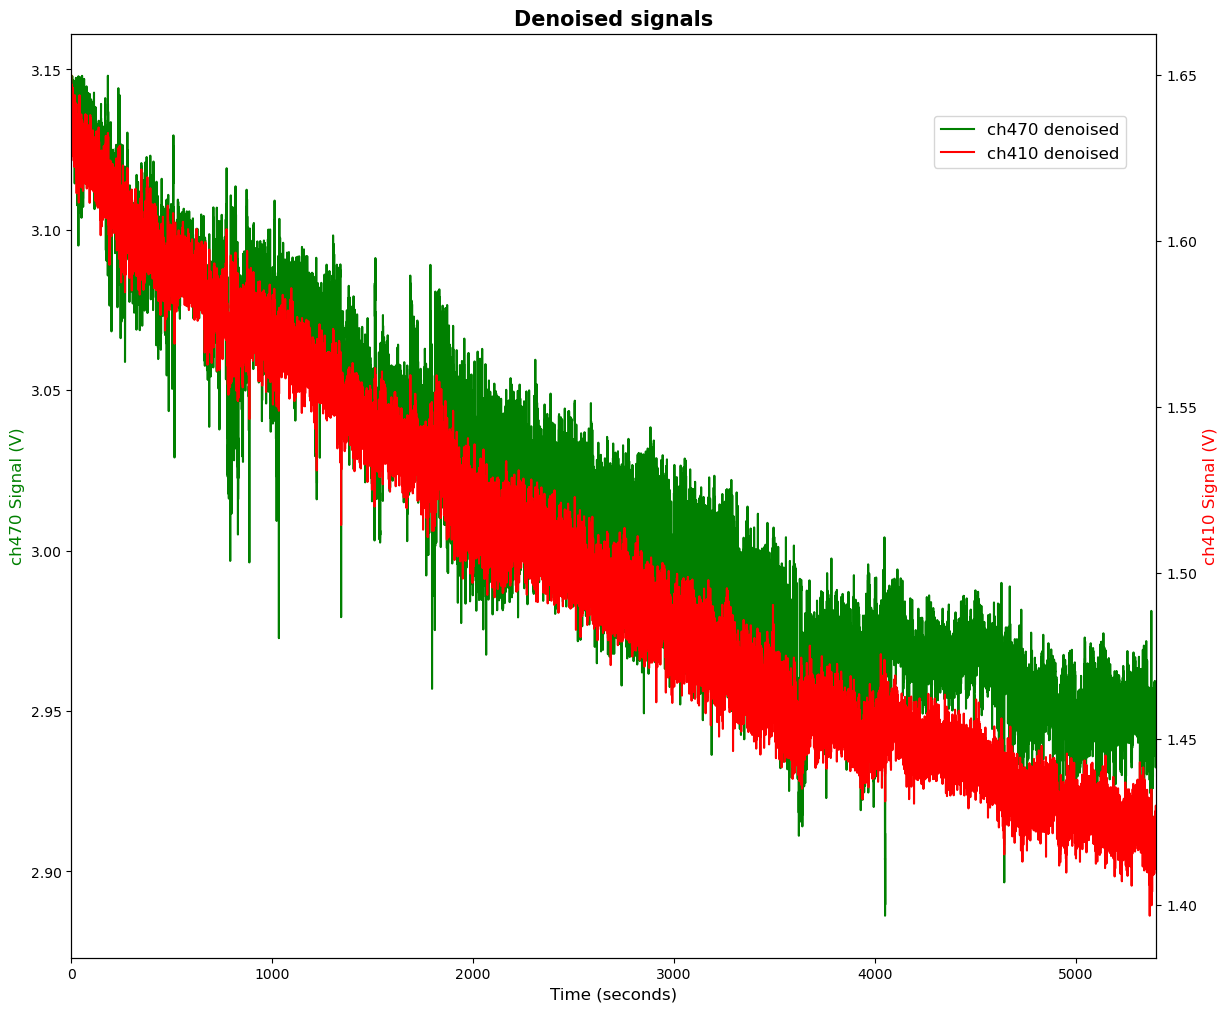

In [ ]:
#ナイキスト周波数は、サンプリングレートの半分の値になる
#Lowpass filter - zero phase filtering (with filtfilt) is used to avoid distorting the signal.
#ここの第二引数がローパスフィルターの値になる
b,a = butter(2, 2, btype='low', fs=sampling_rate)
ch470_denoised = filtfilt(b,a, ch470_raw)
ch410_denoised = filtfilt(b,a, ch410_raw)

fig,ax1=plt.subplots()
plot1=ax1.plot(time_seconds, ch470_denoised, 'g', label='ch470 denoised')
ax2=plt.twinx()
plot2=ax2.plot(time_seconds, ch410_denoised, 'r', label='ch410 denoised')
#eward Cueは私の実験ではいらない（これからもReward関連はコメントアウトしている）
#reward_ticks = ax1.plot(reward_cue_times, np.full(np.size(reward_cue_times), 1.625), label='Reward Cue', color='w', marker="|", mec='k', ms=10)

#ax1.set_ylim(1.25, 1.65)
#ax2.set_ylim(1.35, 1.75)
ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('ch470 Signal (V)', color='g')
ax2.set_ylabel('ch410 Signal (V)', color='r')
ax1.set_title('Denoised signals')

lines = plot1+plot2 #+reward_ticks #line handle for legend
labels = [l.get_label() for l in lines]  
legend = ax1.legend(lines, labels, loc='upper right', bbox_to_anchor=(0.98, 0.92)) 

Let's zoom in on the x axis to see how the lowpass filtering has smoothed the signals.

(1000.0, 1060.0)

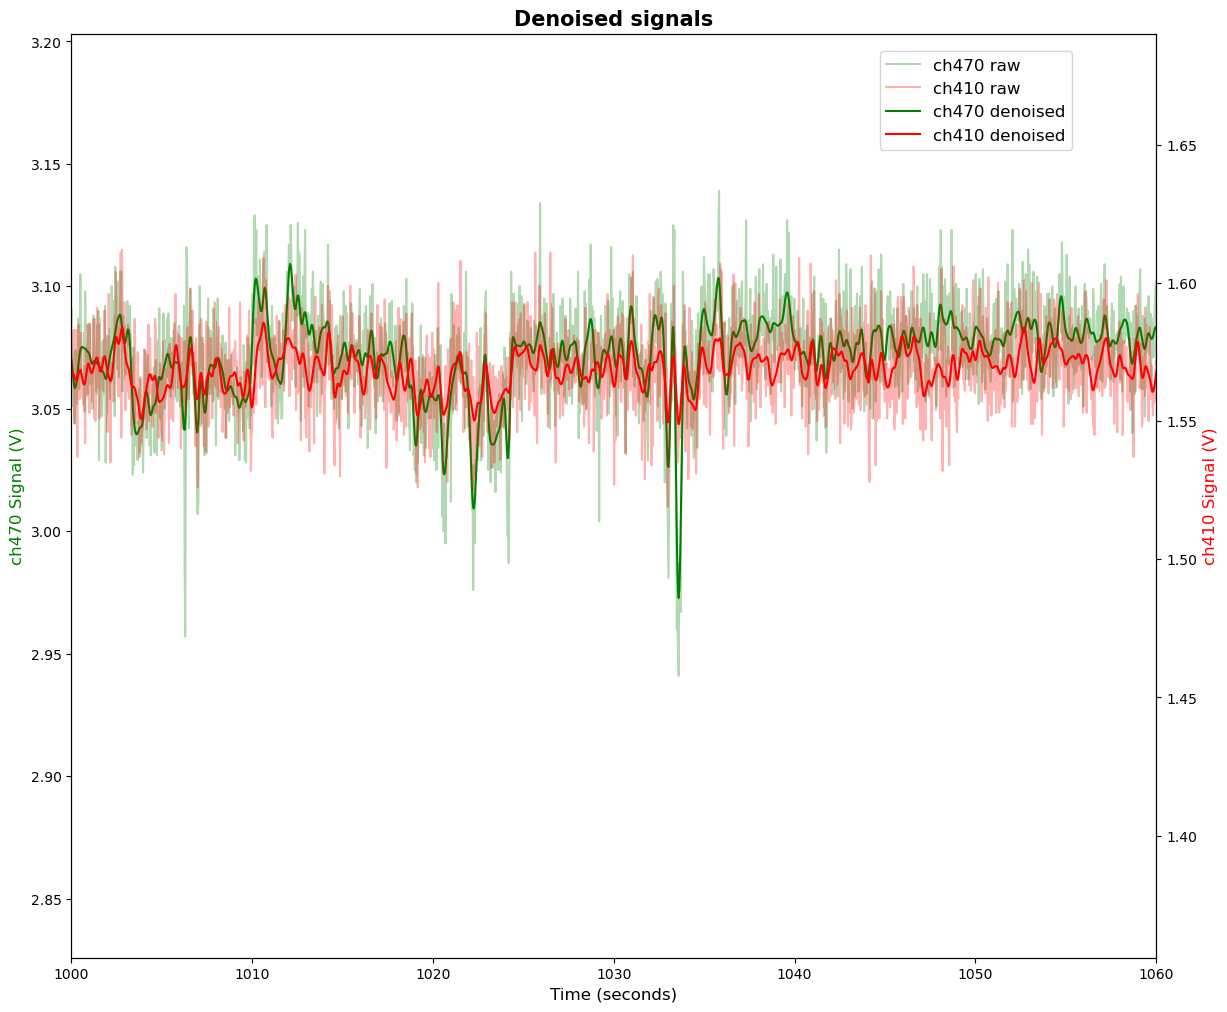

In [23]:
fig,ax1=plt.subplots()
plot1=ax1.plot(time_seconds, ch470_raw, color='g', alpha=0.3, label='ch470 raw')
ax2=plt.twinx()
plot2=ax2.plot(time_seconds, ch410_raw, color='r', alpha=0.3, label='ch410 raw')
plot3=ax1.plot(time_seconds, ch470_denoised, color='g', label='ch470 denoised')
plot4=ax2.plot(time_seconds, ch410_denoised, color='r', label='ch410 denoised')
#reward_ticks = ax1.plot(reward_cue_times, np.full(np.size(reward_cue_times), 1.59), label='Reward Cue',color='w', marker="v", mfc='k', mec='k', ms=8)

ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('ch470 Signal (V)', color='g')
ax2.set_ylabel('ch410 Signal (V)', color='r')
ax1.set_title('Denoised signals')

lines = plot1+plot2 + plot3 + plot4 #+ reward_ticks
labels = [l.get_label() for l in lines]
legend = ax1.legend(lines, labels, loc='upper right', bbox_to_anchor=(0.93, 0.99))
ax1.set_xlim(1000, 1060) # 60 sec window
#ax1.set_ylim(1.4, 1.625)
#ax2.set_ylim(1.4, 1.625);

# Photobleaching correction

Now lets compare some different ways of removing the influence of photobleaching.

### Method 1: Double Exponential Fit

One way of removing the influence of bleaching is to fit an exponential decay to the data and subtract this exponential fit from the signal (note, some groups divide the signal by the baseline rather than subtracting the baseline, see Fiber Photometry Primer for more discussion). In practice we find that a double exponential fit is preferable to a single exponential fit because there are typically multiple sources of fluorescence that contribute to the bleaching (e.g. autofluorescence from fiber, autofluorescence from brain tissue, and flurophore fluorescence), which may bleach at different rates, so a single exponential fit can be overly restrictive.

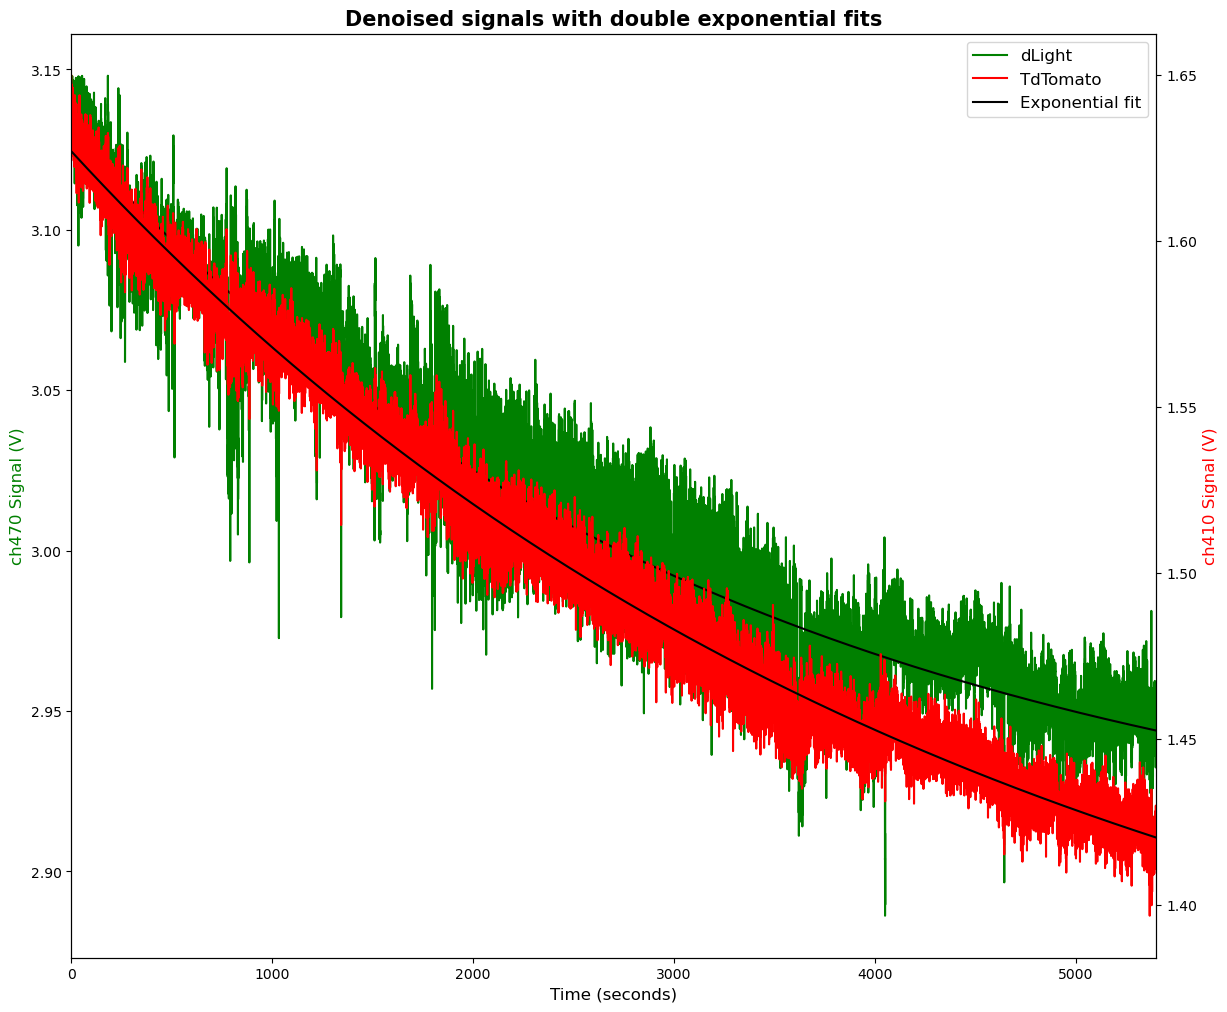

In [24]:
# The double exponential curve we are going to fit.
def double_exponential(t, const, amp_fast, amp_slow, tau_slow, tau_multiplier):
    '''Compute a double exponential function with constant offset.
    Parameters:
    t       : Time vector in seconds.
    const   : Amplitude of the constant offset.
    amp_fast: Amplitude of the fast component.
    amp_slow: Amplitude of the slow component.
    tau_slow: Time constant of slow component in seconds.
    tau_multiplier: Time constant of fast component relative to slow.
    '''
    tau_fast = tau_slow*tau_multiplier
    return const+amp_slow*np.exp(-t/tau_slow)+amp_fast*np.exp(-t/tau_fast)

# Fit curve to ch470 signal.
max_sig = np.max(ch470_denoised)
inital_params = [max_sig/2, max_sig/4, max_sig/4, 3600, 0.1]
bounds = ([0      , 0      , 0      , 600  , 0],
          [max_sig, max_sig, max_sig, 36000, 1])
ch470_parms, parm_cov = curve_fit(double_exponential, time_seconds, ch470_denoised,
                                  p0=inital_params, bounds=bounds, maxfev=1000)
ch470_expfit = double_exponential(time_seconds, *ch470_parms)

# Fit curve to ch410 signal.
max_sig = np.max(ch410_denoised)
inital_params = [max_sig/2, max_sig/4, max_sig/4, 3600, 0.1]
bounds = ([0      , 0      , 0      , 600  , 0],
          [max_sig, max_sig, max_sig, 36000, 1])
ch410_parms, parm_cov = curve_fit(double_exponential, time_seconds, ch410_denoised,
                                  p0=inital_params, bounds=bounds, maxfev=1000)
ch410_expfit = double_exponential(time_seconds, *ch410_parms)

#plot fits over denoised data
fig,ax1=plt.subplots()
plot1=ax1.plot(time_seconds, ch470_denoised, 'g', label='dLight')
plot3=ax1.plot(time_seconds, ch470_expfit, color='k', linewidth=1.5, label='Exponential fit')
ax2=plt.twinx()
plot2=ax2.plot(time_seconds, ch410_denoised, color='r', label='TdTomato')
plot4=ax2.plot(time_seconds, ch410_expfit,color='k', linewidth=1.5)


ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('ch470 Signal (V)', color='g')
ax2.set_ylabel('ch410 Signal (V)', color='r')
ax1.set_title('Denoised signals with double exponential fits')

lines = plot1 + plot2 + plot3
labels = [l.get_label() for l in lines]
legend = ax1.legend(lines, labels, loc='upper right');
#ax1.set_ylim(1.27, 1.62)
#ax2.set_ylim(1.35, 1.7);


In this data there is substantial bleaching in the dLight channel but no appreciable bleaching in the tdTomato.

Now we subtract the exponential fits from the signals.

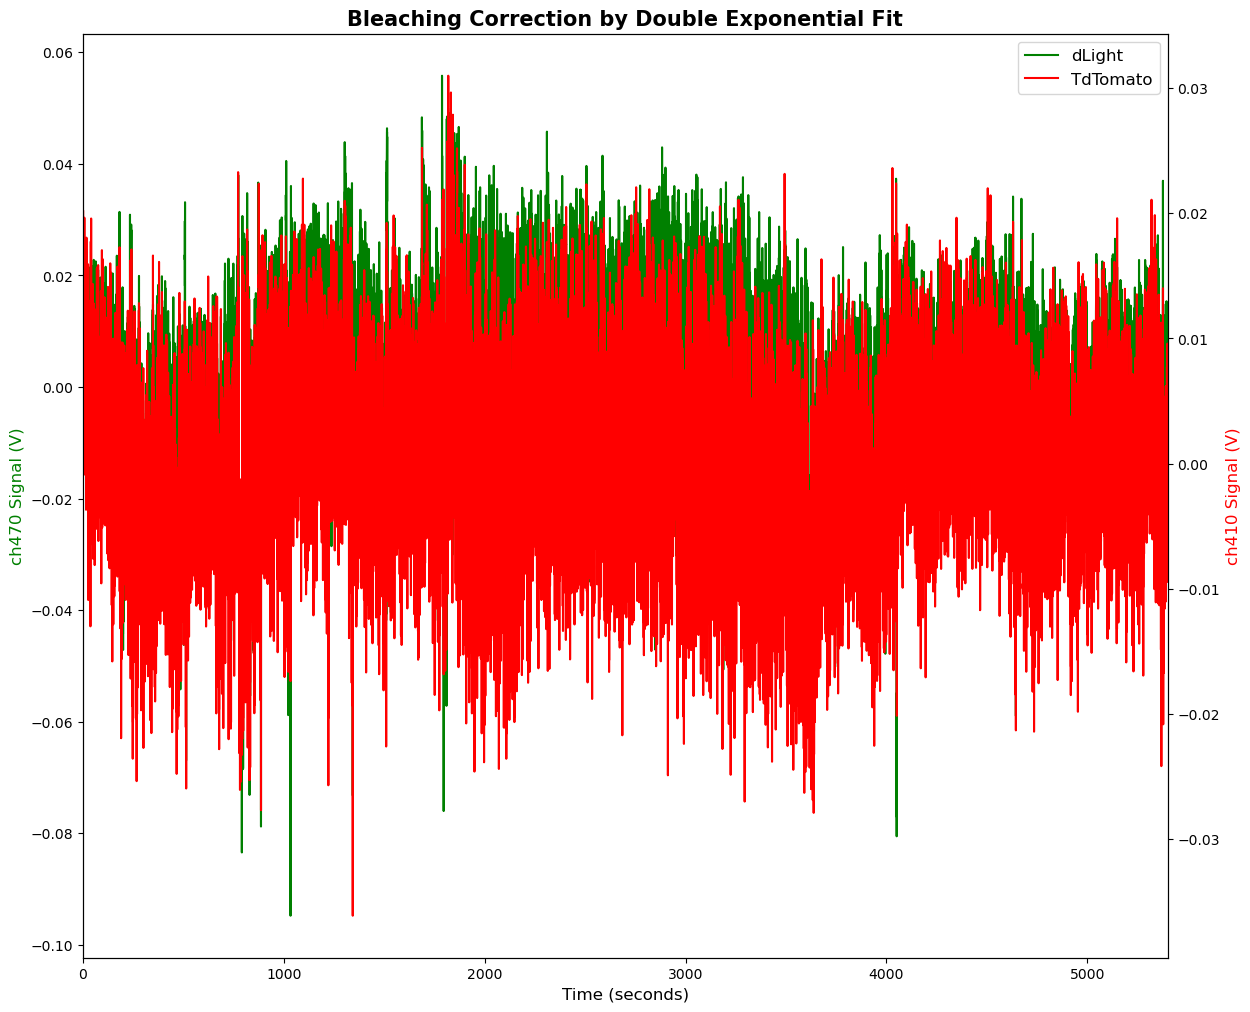

In [25]:
ch470_detrended = ch470_denoised - ch470_expfit
ch410_detrended = ch410_denoised - ch410_expfit

fig,ax1=plt.subplots()
plot1=ax1.plot(time_seconds, ch470_detrended, 'g', label='dLight')
ax2=plt.twinx()
plot2=ax2.plot(time_seconds, ch410_detrended, color='r', label='TdTomato')

ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('ch470 Signal (V)', color='g')
ax2.set_ylabel('ch410 Signal (V)', color='r')
ax1.set_title('Bleaching Correction by Double Exponential Fit')

lines = plot1+plot2
labels = [l.get_label() for l in lines]
legend = ax1.legend(lines, labels, loc='upper right');
#ax1.set_ylim(-0.18, 0.12)
#ax2.set_ylim(-0.1, 0.2);


### Method 2: High Pass Filter
A simpler way to remove slow changes is simply to highpass filter the signal with a very low cutoff frequency. Here we will high pass at 0.001Hz, which correponds to a period of 16 minutes.  All components of the signal changing on a slower timescale than this will be removed, which removes the drift due to bleaching, but will also remove any physiological variation in the signal on very slow timescales.


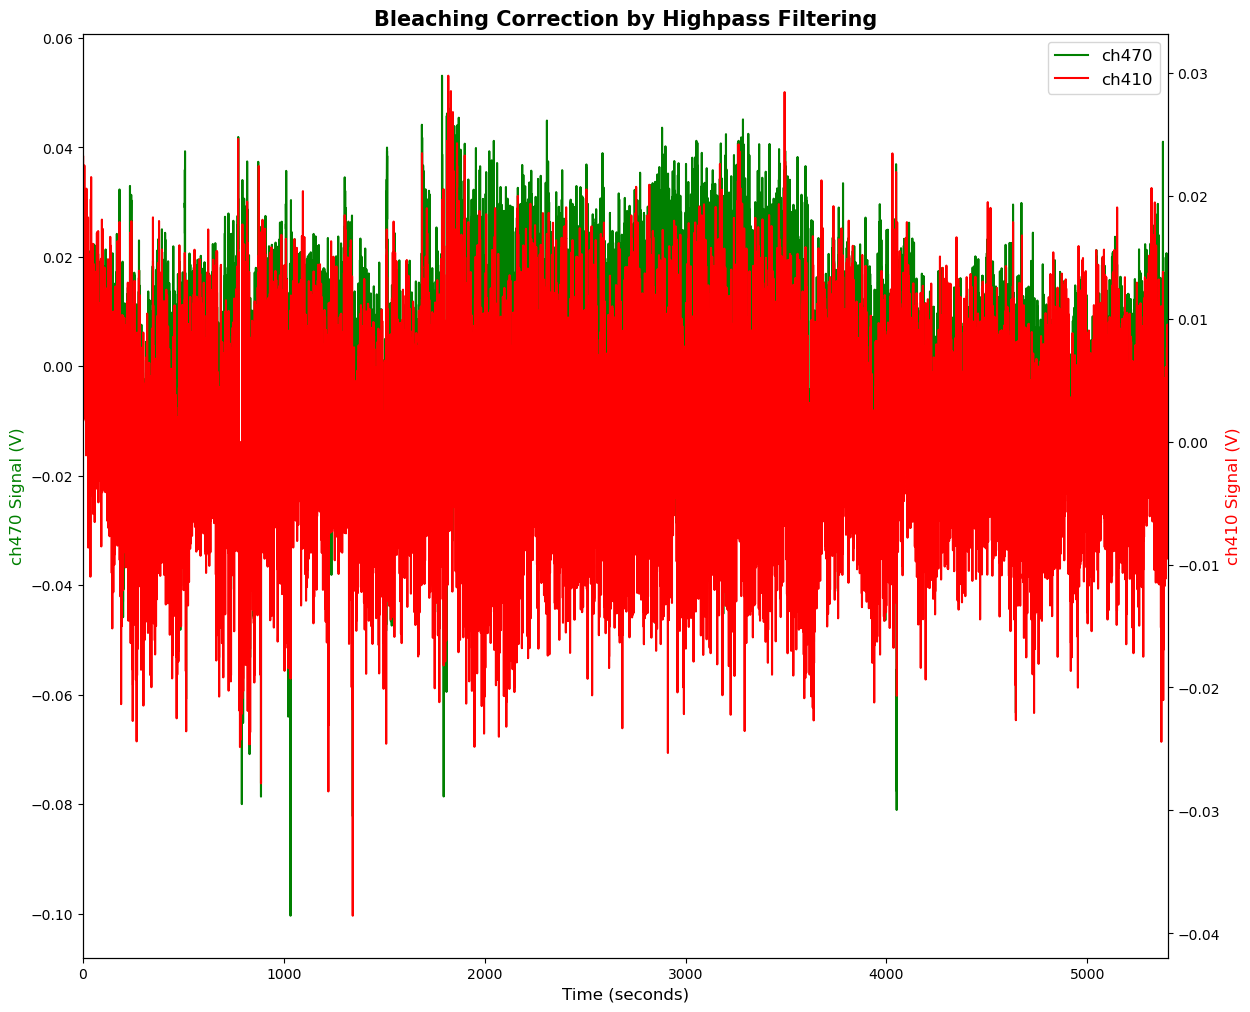

In [26]:
b,a = butter(2, 0.001, btype='high', fs=sampling_rate)
ch470_highpass = filtfilt(b,a, ch470_denoised, padtype='even')
ch410_highpass = filtfilt(b,a, ch410_denoised, padtype='even')


fig,ax1=plt.subplots()
plot1=ax1.plot(time_seconds, ch470_highpass, 'g', label='ch470')
ax2=plt.twinx()
plot2=ax2.plot(time_seconds, ch410_highpass, color='r', label='ch410')

ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('ch470 Signal (V)', color='g')
ax2.set_ylabel('ch410 Signal (V)', color='r')
ax1.set_title('Bleaching Correction by Highpass Filtering')

lines = plot1+plot2
labels = [l.get_label() for l in lines]
legend = ax1.legend(lines, labels, loc='upper right');
#ax1.set_ylim(-0.18, 0.12)
#ax2.set_ylim(-0.1, 0.2);


# Motion correction

We now do motion correction by finding the best linear fit of the TdTomato signal to the dLight signal and subtracting this estimated motion component from the dLight signal.  We will use the data that was bleaching corrected using the double exponential fit as this is less likely to remove meaningful slow variation in the signals.

Slope    : 1.382
R-squared: 0.445


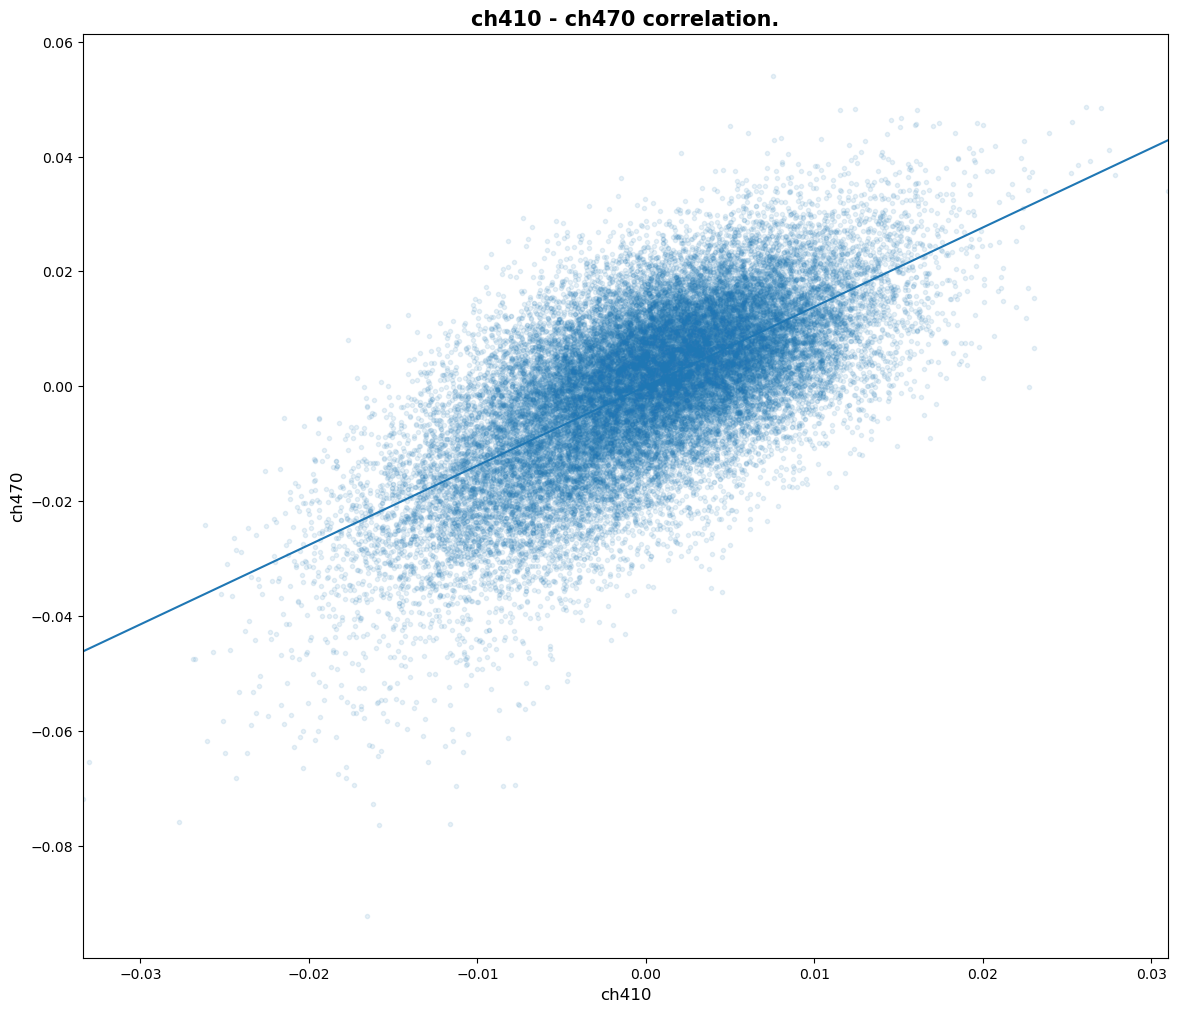

In [27]:
slope, intercept, r_value, p_value, std_err = linregress(x=ch410_detrended, y=ch470_detrended)

plt.scatter(ch410_detrended[::5], ch470_detrended[::5],alpha=0.1, marker='.')
x = np.array(plt.xlim())
plt.plot(x, intercept+slope*x)
plt.xlabel('ch410')
plt.ylabel('ch470')
plt.title('ch410 - ch470 correlation.')

print('Slope    : {:.3f}'.format(slope))
print('R-squared: {:.3f}'.format(r_value**2))

We can see that as expected the signals have a positive correlation due to the common contribution of movement to each.  We can also see from the slope of the fit being 0.23 that the movement artifacts in the dLight channel are aproximately 5x smaller than in the tdTomato channel.  This is likely because the shorter wavelength excitation light used for dLight excites much more autofluorescence from patch cords and bulk brain tissue, and as a large area diffuse source, autofluorescence is generally less affected by movement. For the same reason movement artifacts in isosbestic control channels, which use short wavelength excitation, are typically smaller than in the dLight channel.

We now calculate the estimated motion component of the dLight signal and subtract to get the motion corrected signal.

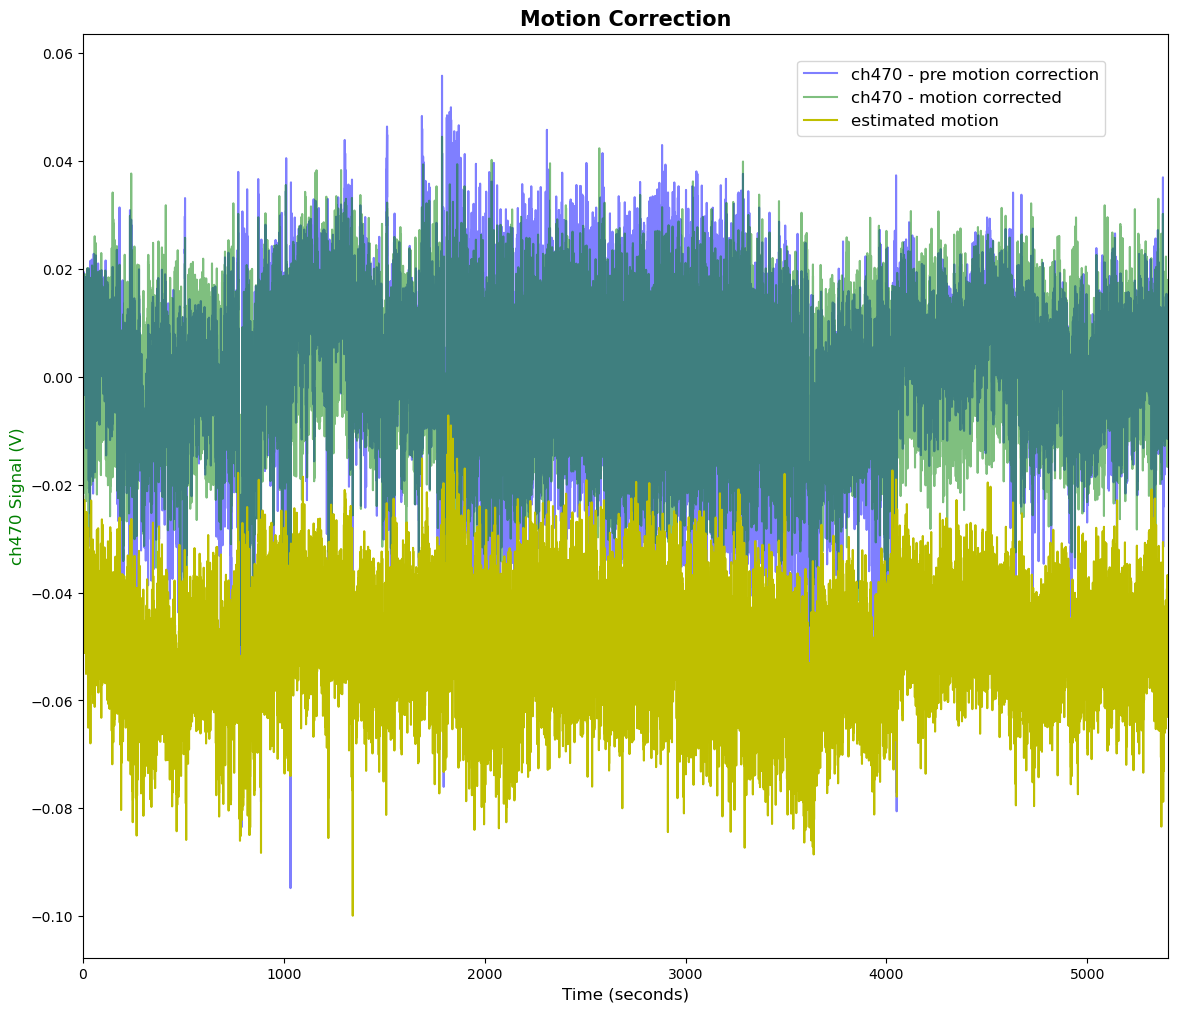

In [28]:
ch470_est_motion = intercept + slope * ch410_detrended
ch470_corrected = ch470_detrended - ch470_est_motion

fig,ax1=plt.subplots()
plot1=ax1.plot(time_seconds, ch470_detrended, 'b' , label='ch470 - pre motion correction', alpha=0.5)
plot3=ax1.plot(time_seconds, ch470_corrected, 'g', label='ch470 - motion corrected', alpha=0.5)
plot4=ax1.plot(time_seconds, ch470_est_motion - 0.05, 'y', label='estimated motion')
#reward_ticks = ax1.plot(reward_cue_times, np.full(np.size(reward_cue_times), 0.08), label='Reward Cue',color='w', marker="v", mfc='k', mec='k', ms=8)

ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('ch470 Signal (V)', color='g')
ax1.set_title('Motion Correction')

lines = plot1+plot3+plot4 #+ reward_ticks
labels = [l.get_label() for l in lines]
legend = ax1.legend(lines, labels, loc='upper right', bbox_to_anchor=(0.95, 0.98))

#ax1.set_xlim(1000, 1060)  # 60 sec window
#ax1.set_ylim(-0.075, 0.1);

# Normalisation

Typically in a photometry experiment we want to combine data across sessions and/or subjects.  This is complicated by the fact that different sessions may have different levels of fluorphore expression, excitation light and autofluorescence.  It is therefore desirable to normalise the data to reduce this variability.  The two most widely used ways of doing this are computing dF/F or z-scores.

### Method 1: dF/F

To compute dF/F we divide the signal changes (dF) by the baseline fluorescence (F) and multiply by 100 to convert to percent. The dF is just the motion corrected signal plotted above.  The baseline fluorescence F changes over the course of the session due to photobleaching, and is just the baseline we estimated with our double exponential fit.

(1000.0, 1060.0)

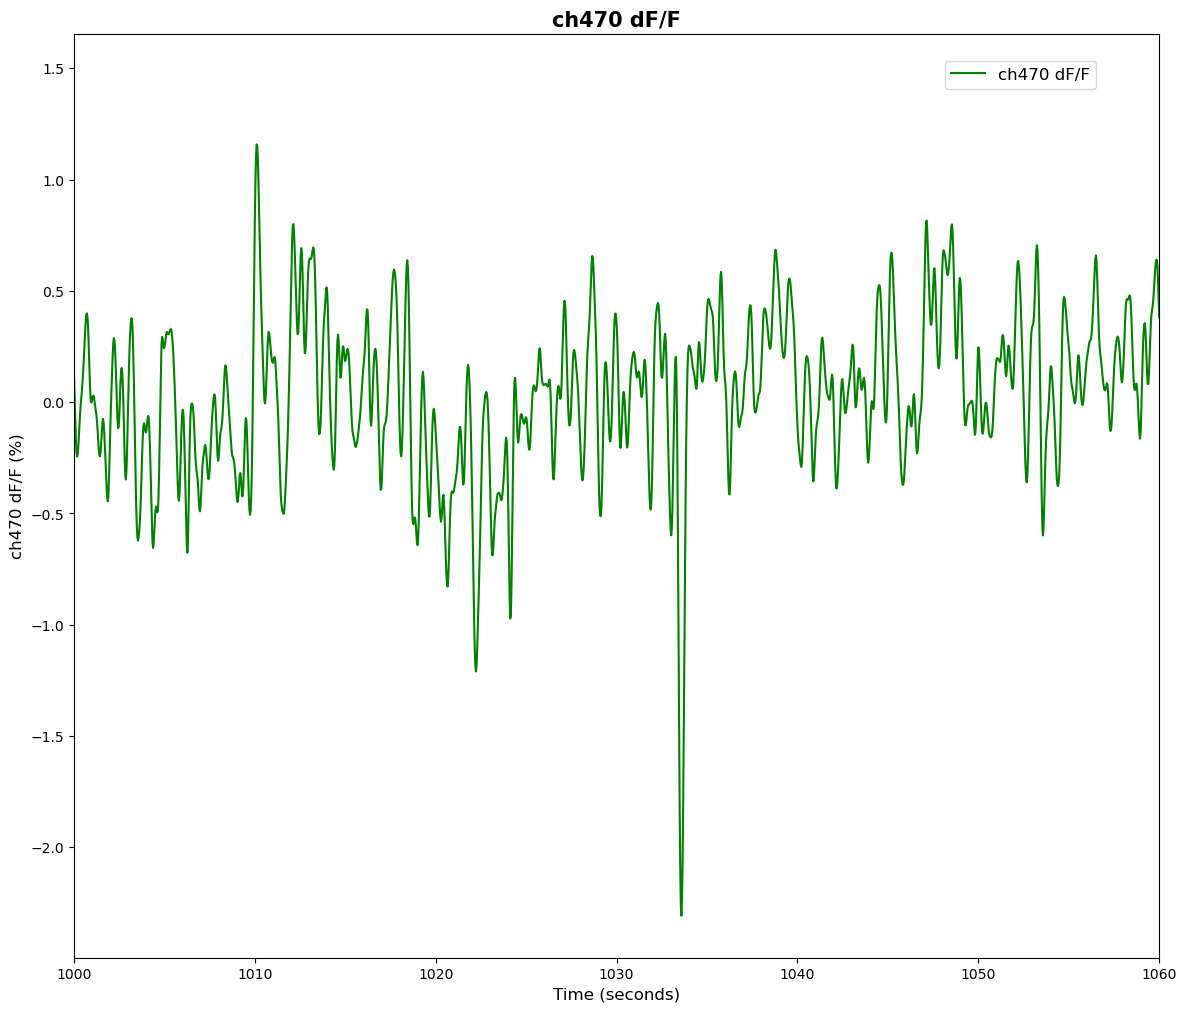

In [29]:
ch470_dF_F = 100*ch470_corrected/ch470_expfit

fig,ax1=plt.subplots()
plot1=ax1.plot(time_seconds, ch470_dF_F, 'g', label='ch470 dF/F')
#reward_ticks = ax1.plot(reward_cue_times, np.full(np.size(reward_cue_times), 6), label='Reward Cue',color='w', marker="v", mfc='k', mec='k', ms=8)

ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('ch470 dF/F (%)')
ax1.set_title('ch470 dF/F')

lines = plot1 #+ reward_ticks
labels = [l.get_label() for l in lines]
legend = ax1.legend(lines, labels, loc='upper right', bbox_to_anchor=(0.95, 0.98))

ax1.set_xlim(1000, 1060)
#ax1.set_ylim(-3, 7);

### Method 2: Z-scoring

Alternatively, we can normalise the data by z-scoring each session - i.e. subtracting the mean and dividing by the standard deviation.

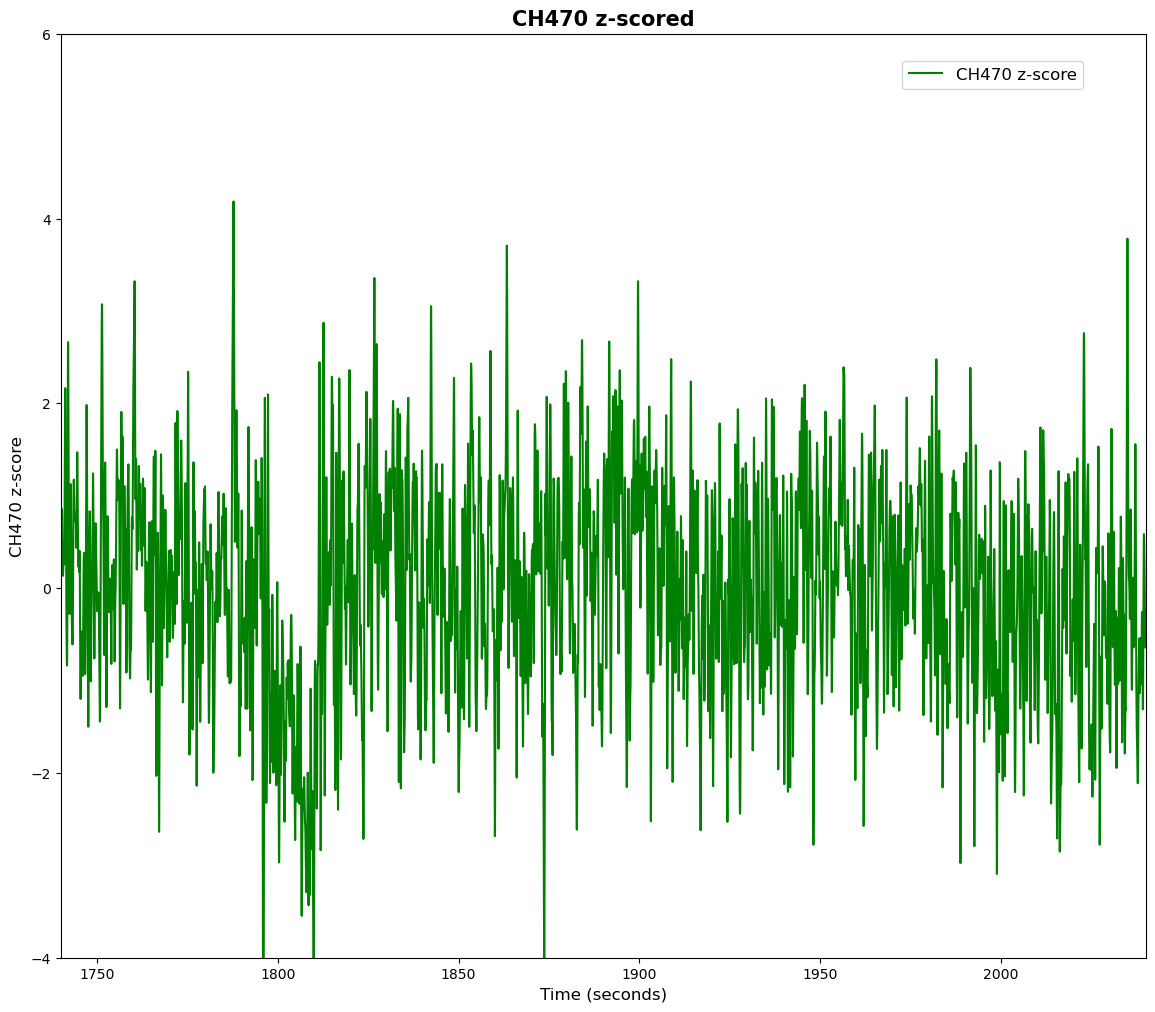

In [30]:
ch470_zscored = (ch470_corrected-np.mean(ch470_corrected))/np.std(ch470_corrected)


fig,ax1=plt.subplots()
plot1=ax1.plot(time_seconds, ch470_zscored, 'g', label='CH470 z-score')
#reward_ticks = ax1.plot(reward_cue_times, np.full(np.size(reward_cue_times), 6), label='Reward Cue',color='w', marker="v", mfc='k', mec='k', ms=8)

ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('CH470 z-score')
ax1.set_title('CH470 z-scored')

lines = plot1 #+ reward_ticks
labels = [l.get_label() for l in lines]
legend = ax1.legend(lines, labels, loc='upper right', bbox_to_anchor=(0.95, 0.98))

ax1.set_xlim(1740, 2040)
ax1.set_ylim(-4, 6);



(c) Copyright Thomas Akam & Lauren Burgeno 2019 - 2023.  Released under the [GPL3 Licence](https://www.gnu.org/licenses/gpl-3.0.en.html).

In [ ]:
processed_df = pd.DataFrame({
    'Time_seconds': time_seconds,
    'dF_F (%)': ch470_dF_F,
    'Z_score': ch470_zscored
})

output_filename = f"waltonlab_{filename}"
output_path = os.path.join(folder_path, output_filename)
processed_df.to_csv(output_path, index=False)

解析済みのデータが正常に保存されました。
ファイルパス: /Users/tic/Desktop/蛍光データ/waltonlab_Fluorescence_2025_09_04_slc1_clip90.csv
